In [19]:
import torch
from torch import nn
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import numpy as np
from skorch import NeuralNetClassifier
import itertools
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Extract Dataset
# https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

input_file = "Data/features_3_sec.csv"

with open(input_file) as f:
    f.readline()
    data = np.loadtxt(f, delimiter=',', dtype=np.object_)

labels = [
    'blues', 'classical', 'country', 'disco', 'hiphop', 
    'jazz', 'metal', 'pop', 'reggae', 'rock'
]

X = data[:, 1:-1].astype(np.float32)

min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
X = min_max_scaler.fit_transform(X)

y = [labels.index(l) for l in data[:, -1]]


train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

train_X = torch.tensor(train_X, dtype=torch.float32)
test_X  = torch.tensor(test_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.long)
test_y  = torch.tensor(test_y, dtype=torch.long)


In [21]:
torch.manual_seed(123456789)

class Network(nn.Module):
    def __init__(self, in_features: int, out_features: int, dropout: float = 0.5):
        super().__init__()

        self.l1 = nn.Sequential(
            nn.Linear(in_features, l1_features := 512),
            nn.BatchNorm1d(l1_features),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.l2 = nn.Sequential(
            nn.Linear(l1_features, l2_features := 256),
            nn.BatchNorm1d(l2_features),
            nn.ReLU(),
        )

        self.l3 = nn.Sequential(
            nn.Linear(l2_features, l3_features := 128),
            nn.BatchNorm1d(l3_features),
            nn.ReLU(),
        )

        self.l4 = nn.Sequential(
            nn.Linear(l3_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.ReLU(),
        )


    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = torch.log_softmax(output, dim=1)
        return output

In [22]:
classifier = NeuralNetClassifier(
    # Module
    module=Network,
    module__in_features=58,
    module__out_features=10,
    module__dropout=0.15,
    # Criterion
    criterion=nn.CrossEntropyLoss,
    criterion__reduction='mean',
    # Optimizer
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=0.002,
    lr=0.0001,
    # Training
    max_epochs=250,
    batch_size=256,
    # Misc
    verbose=1,
    device=device,
)

classifier.fit(train_X, train_y)
prediction_probs = classifier.predict(test_X)

print(accuracy_score(test_y, prediction_probs))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.9652       0.3340        2.0912  0.1152
      2        1.5582       0.6016        1.5104  0.1152
      3        1.3990       0.6635        1.3193  0.1170
      4        1.3011       0.6961        1.2280  0.1229
      5        1.2237       0.7230        1.1617  0.1192
      6        1.1647       0.7398        1.1126  0.1182
      7        1.1143       0.7548        1.0724  0.1169
      8        1.0729       0.7680        1.0386  0.1929
      9        1.0383       0.7742        1.0147  0.1197
     10        1.0051       0.7842        0.9852  0.1186
     11        0.9721       0.7936        0.9611  0.1189
     12        0.9545       0.8055        0.9434  0.1163
     13        0.9280       0.8055        0.9285  0.1195
     14        0.9051       0.8205        0.9039  0.1213
     15        0.8860       0.8224        0.8894  0.1194
     16        0.8659       0.8

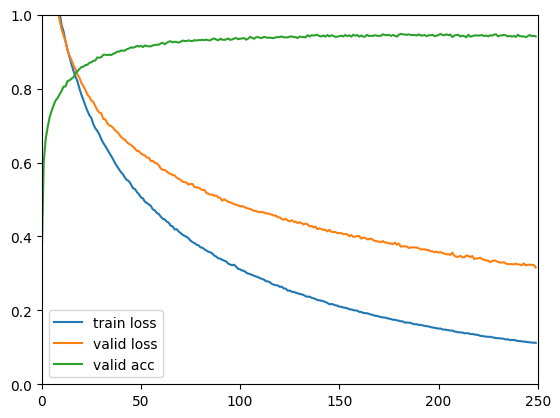

In [23]:
ax = plt.gca()
ax.set_ylim([0, 1])
ax.set_xlim([0, 250])

plt.plot(classifier.history[:, 'train_loss'], label='train loss')
plt.plot(classifier.history[:, 'valid_loss'], label='valid loss')
plt.plot(classifier.history[:, 'valid_acc'], label='valid acc')
plt.legend()
plt.show()

